# 逆誤差伝播によるXOR判別モデルの訓練
授業では各ニューロンをそれぞれ別で訓練したが、<br>
今回は最終目標のラベルだけを見せて学習ができるモデルを機械学習ライブラリを使わずに実装する。

In [8]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x):
    return x * (1 - x)

# Input dataset
df = pd.DataFrame({
    'x': [0, 0, 1, 1],
    'y': [0, 1, 0, 1],
    'label': [0, 1, 1, 0]
})

# 入力Xの特徴量は2つ、インスタンスは4つ
# バイアス項を含めてXを拡張
X = df[['x', 'y']].values  # (4, 2)
y = df['label'].values.reshape(-1, 1)  # (4, 1)

# バイアス項を先頭に追加
X_ext = np.hstack([np.ones((X.shape[0], 1)), X])  # (4, 3)

パラメータを初期化する。再現性のためにrandom.seedを設定しておく

In [9]:
# 重み初期化（バイアス含む）
np.random.seed(42)
theta1 = np.random.randn(3, 2)*0.1  # (3, 2): 1層目（バイアス含む）
theta2 = np.random.randn(3, 1)*0.1  # (3, 1): 2層目（バイアス含む）

初期パラメータで順伝播をして、損失を確認

In [10]:
# 順伝播
z1 = X_ext @ theta1  # (4, 2)
a1 = sigmoid(z1)    # (4, 2)
a1_ext = np.hstack([np.ones((a1.shape[0], 1)), a1])  # (4, 3)
z2 = a1_ext @ theta2  # (4, 1)
y_pred = sigmoid(z2)  # (4, 1)

# ロス（Log Loss）
E = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
print(f'Initial Loss: {E:.4f}')

Initial Loss: 0.6969


順伝播、逆伝播を関数で呼び出せるように定義。<br>
ここで、誤差の逆伝播のための勾配は微分の連鎖律を用いて計算する。<br>
$\frac{\partial \hat{y}}{\partial z_2}$は、損失関数がクロスエントロピー、活性化関数がシグモイドの場合、非常にきれいに計算ができて、結果は $(\hat{y} - y)$ となる。この出力層の誤差を $\delta_2$ と置く。($z_2$は二層目の隠し層のベクトル)

In [11]:
def forwardpropagation(X_ext, theta1, theta2, sigmoid):
    z1 = X_ext @ theta1
    a1 = sigmoid(z1)
    a1_ext = np.hstack([np.ones((a1.shape[0], 1)), a1])
    z2 = a1_ext @ theta2
    y_pred = sigmoid(z2)
    return y_pred

def backpropagation(X_ext, y, theta1, theta2, sigmoid, sigmoid_derivative):
    # 順伝播
    z1 = X_ext @ theta1
    a1 = sigmoid(z1)
    a1_ext = np.hstack([np.ones((a1.shape[0], 1)), a1])
    z2 = a1_ext @ theta2
    y_pred = sigmoid(z2)

    # 誤差逆伝播
    # 出力層の誤差
    delta2 = y_pred - y

    # 隠れ層の誤差
    error_hidden = delta2 @ theta2[1:, :].T
    delta1 = error_hidden * sigmoid_derivative(a1)

    # 各層の重みの勾配を計算
    dtheta2 = a1_ext.T @ delta2
    dtheta1 = X_ext.T @ delta1

    return dtheta1, dtheta2

学習率、エポック数を設定して、バッチ勾配降下法によりモデルの学習を行う。

In [12]:
# 学習率とエポック数の設定
learning_rate = 0.5
n_epochs = 20000

# 学習経過のロスを記録
loss_history = []

for epoch in range(n_epochs):
    # 順伝播
    y_pred = forwardpropagation(X_ext, theta1, theta2, sigmoid)
    # ロス計算
    E = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
    loss_history.append(E)
    # 逆伝播
    dtheta1, dtheta2 = backpropagation(X_ext, y, theta1, theta2, sigmoid, sigmoid_derivative)
    # パラメータ更新
    theta1 -= learning_rate * dtheta1
    theta2 -= learning_rate * dtheta2

In [13]:
# 最終結果の順伝播
z1 = X_ext @ theta1
a1 = sigmoid(z1)
a1_ext = np.hstack([np.ones((a1.shape[0], 1)), a1])
z2 = a1_ext @ theta2
y_pred = sigmoid(z2)
E = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))

print('最終順伝播出力 (y_pred):\n', y_pred)
print('最終ロス E:', E)
print('theta1 (1層目の勾配):\n', theta1)
print('theta2 (2層目の勾配):\n', theta2)

最終順伝播出力 (y_pred):
 [[2.81483129e-04]
 [9.99607709e-01]
 [9.99736493e-01]
 [2.47376750e-04]]
最終ロス E: 0.00029619997334256825
theta1 (1層目の勾配):
 [[-4.04577036  4.09544234]
 [ 7.71633994  8.44672934]
 [-7.99259269 -8.20835352]]
theta2 (2層目の勾配):
 [[  8.11448976]
 [ 17.42472382]
 [-16.86545529]]


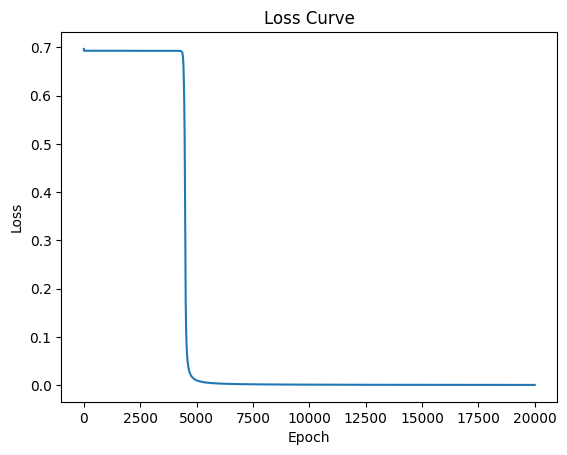

In [14]:
# ロスの推移をプロット
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

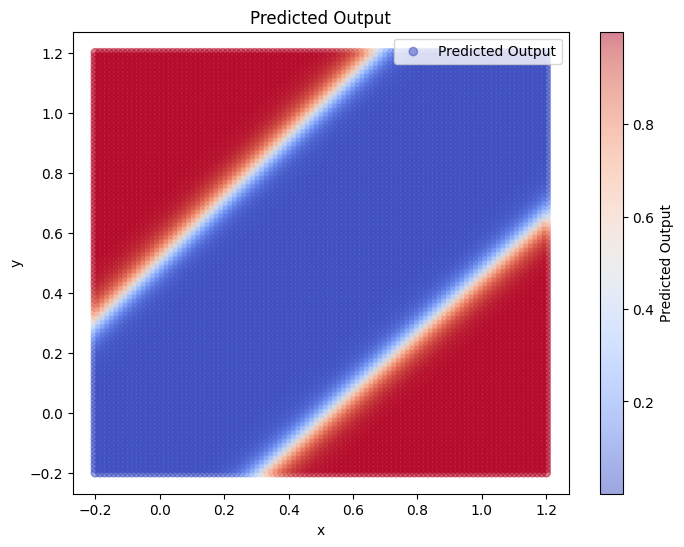

In [15]:
# モデルをヒートマップで可視化
x_new, y_new = np.mgrid[-0.2:1.2:100j, -0.2:1.2:100j]
X_new = np.column_stack([x_new.ravel(), y_new.ravel()])
X_new_ext = np.hstack([np.ones((X_new.shape[0], 1)), X_new])  # バイアス項を追加
y_new_pred = forwardpropagation(X_new_ext, theta1, theta2, sigmoid)
# 予測結果をプロット
plt.figure(figsize=(8, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new_pred.flatten(), cmap='coolwarm', alpha=0.5, label='Predicted Output')
plt.colorbar(label='Predicted Output')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Output')
plt.legend()
plt.show()